In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os.path
import seaborn as sns
from pathlib import Path
# from pyramid.arima import auto_arima
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from ARIMA_PermEnt import weighted_perm_entropy, min_weighted_perm_entropy,permutated_entropy
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
import math
import copy
import time

plt.style.use('seaborn-whitegrid')
%matplotlib inline  

In [4]:

SMALL_SIZE = 16
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [5]:
#in-sample prediction
def in_sample_prediction(ts):
    modl = auto_arima(ts, max_q=3, m=7,
                               seasonal=True,
                               trace=False,
                               error_action='ignore',  
                               suppress_warnings=True, 
                               stepwise=True)

    pred = modl.predict_in_sample()
#     pred = pd.DataFrame(pred,index = ts.index,columns=['Prediction'])
#     pd.concat([ts,pred],axis=1).plot()
    # Print the error:
#     print("Test NRMSE: %.3f" % (np.sqrt(mean_squared_error(ts, pred))/np.mean(ts)))
    return (np.sqrt(mean_squared_error(ts, pred))/np.mean(ts))

In [6]:
#most significant autocorrelation lag
def max_lag_autocorr(ts,lags=7):
    ac1 = 0
    max_lag = 0
    for i in range(1,lags+1):
        ac = np.abs(ts.autocorr(lag=i))
        if ac > ac1:
            ac1 = ac
            max_lag = i
    return max_lag , ac1

In [7]:
def plot_entropy(df_results, p_sample, label):
    df1 = df_results[df_results.user==label]
    df = df1.groupby(['sample_rate']).median()
    df_q1 = df1.groupby(['sample_rate']).quantile(0.25)
    df_q3 = df1.groupby(['sample_rate']).quantile(0.75)
    
    x = [1.] + p_sample
#     x = 1.-np.array(x)
    y = [df['entropy'][p_sample[0]]]+[df['entropy_sample'][p] for p in p_sample]
    plt.plot(x,y,label=label, linewidth=1,alpha=0.5)
    y_q1 = [df_q1['entropy'][p_sample[0]]]+[df_q1['entropy_sample'][p] for p in p_sample]
    y_q3 = [df_q3['entropy'][p_sample[0]]]+[df_q3['entropy_sample'][p] for p in p_sample]
    plt.fill_between(x, y_q1, y_q3, alpha=0.1)
    
    return x,y
    

def plot_autocorr(df_results, p_sample, label):
    df1 = df_results[df_results.user==label]
    df = df1.groupby(['sample_rate']).median()
    df_q1 = df1.groupby(['sample_rate']).quantile(0.25)
    df_q3 = df1.groupby(['sample_rate']).quantile(0.75)
    x = [1.] + p_sample
#     x = 1.-np.array(x)
    y = [df['autocorr'][p_sample[0]]]+[df['autcorr_sample'][p] for p in p_sample]
    plt.plot(x,y,label=label, linewidth=1,alpha=0.8)
    y_q1 = [df_q1['autocorr'][p_sample[0]]]+[df_q1['autcorr_sample'][p] for p in p_sample]
    y_q3 = [df_q3['autocorr'][p_sample[0]]]+[df_q3['autcorr_sample'][p] for p in p_sample]
    plt.fill_between(x, y_q1, y_q3, alpha=0.1) 
    
    return x,y

    
    
def plot_entropy_ratio(df_results, p_sample, label):
    df1 = df_results[df_results.user==label].copy()
    df1['ratio'] =  df1['entropy_sample']/df1['entropy']
    df = df1.groupby(['sample_rate']).median()
    df_q1 = df1.groupby(['sample_rate']).quantile(0.25)
    df_q3 = df1.groupby(['sample_rate']).quantile(0.75)
    x = [1.] + p_sample
#     x = 1.-np.array(x)
    y = [1.]+[df['ratio'][p] for p in p_sample]
    plt.plot(x,y,label=label,linewidth=1,alpha=0.8)
    y_q1 = [1.0]+[df_q1['ratio'][p] for p in p_sample]
    y_q3 = [1.0]+[df_q3['ratio'][p] for p in p_sample]
    plt.fill_between(x, y_q1, y_q3, alpha=0.1)  
    
    return x,y

def plot_autocorr_ratio_theoretical(df_results, p_sample, label):
    df1 = df_results[df_results.user==label]
#     df1['ratio'] =  df1['entropy_sample']/df1['entropy']
    df = df1.groupby(['sample_rate']).median()
    df_q1 = df1.groupby(['sample_rate']).quantile(0.25)
    df_q3 = df1.groupby(['sample_rate']).quantile(0.75)
    x = [1.] + p_sample
#     x = 1.-np.array(x)
    y = [1.]+[df['x_norm'][p] for p in p_sample]
    plt.plot(x,y,label=label,linewidth=1,alpha=0.8)
    y_q1 = [1.0]+[df_q1['x_norm'][p] for p in p_sample]
    y_q3 = [1.0]+[df_q3['x_norm'][p] for p in p_sample]
    plt.fill_between(x, y_q1, y_q3, alpha=0.1)  
    
    return x,y
    
    
def plot_autocorr_ratio(df_results, p_sample, label):
    df1 = df_results[df_results.user==label].copy()
    df1['ratio'] =  df1['autcorr_sample']/df1['autocorr']
    df = df1.groupby(['sample_rate']).median()
    df_q1 = df1.groupby(['sample_rate']).quantile(0.25)
    df_q3 = df1.groupby(['sample_rate']).quantile(0.75)
    x = [1.] + p_sample
#     x = 1.-np.array(x)
    y = [1.]+[df['ratio'][p] for p in p_sample]
    plt.plot(x,y,label=label, linewidth=1,alpha=1.)
    y_q1 = [1.]+[df_q1['ratio'][p] for p in p_sample]
    y_q3 = [1.]+[df_q3['ratio'][p] for p in p_sample]
    plt.fill_between(x, y_q1, y_q3, alpha=0.05) 

    return x,y


    

def plot_autocorr_ratio2(df_results, p_sample, label):
    df1 = df_results[df_results.user==label]
    df1['ratio'] =  df1['autcorr_sample']/df1['autocorr']
    df = df1.groupby(['sample_rate']).median()
    df_q1 = df1.groupby(['sample_rate']).quantile(0.25)
    df_q3 = df1.groupby(['sample_rate']).quantile(0.75)
    x = [1.] + p_sample
#     x = 1.-np.array(x)
    y = [1.]+[df['ratio'][p] for p in p_sample]
    plt.scatter(x,y,label=label, linewidth=1,alpha=0.8)
    y_q1 = [1.]+[df_q1['ratio'][p] for p in p_sample]
    y_q3 = [1.]+[df_q3['ratio'][p] for p in p_sample]
#     plt.fill_between(x, y_q1, y_q3, alpha=0.1) 

In [8]:
def sample_entropy_autocorr(df, N=10, p_sample = [0.8, 0.5, 0.1], n_samples = 10):
    users = df.groupby(['user']).size().reset_index(name='count').sort_values(['count'], ascending=False)
    users =  users['user'].values
    results = []
    n_users = 0
    for user in users:
        if n_users>=N:
            break
        df_user = df.loc[df['user']==user].copy()
        df_user['time'] = pd.to_datetime(df_user['time']).apply(lambda x: x.strftime('%Y-%m-%d'))
        ts = df_user.groupby(['time'],as_index=False).count()
        ts['time'] = pd.to_datetime(ts['time'])
        ts.set_index('time', inplace=True)
        ts=ts['user']
        ts = ts+100 #autocorelation and entropy are shift invariant, and avoids removing all points when sampling
        #fill missing dates with 0
        all_days = pd.date_range(ts.index.min(), ts.index.max(), freq='D')
        ts = ts.reindex(all_days,fill_value=0)
        if ts.shape[0]<50:
            continue
        
        order, delay = min_weighted_perm_entropy(ts, min_order=3, max_order=5, min_delay=1, max_delay=7, normalize=True)
        entropy = weighted_perm_entropy(ts, order=order,delay=delay, normalize=True)
        max_lag, autocorr =  max_lag_autocorr(ts, lags=10)
        var = np.var(ts)
        mean = np.mean(ts)
        print(user, entropy, order, delay, ts.shape[0])

        k = 0
        while k < n_samples:
            k+=1
            for p in p_sample:
                ts_sample = ts.apply(lambda x: np.random.binomial(x, p, size = 1)[0] if not np.isnan(x) else None )
                entropy_sample = weighted_perm_entropy(ts_sample, order=order,delay=delay, normalize=True)
                autcorr_sample = np.abs(ts_sample.autocorr(lag=max_lag))
                results.append([user,entropy_sample,entropy,entropy_sample/entropy,order,p, autocorr, autcorr_sample, max_lag,var,mean])
#                 print(user, entropy, entropy_sample, order, autocorr, autcorr_sample, max_lag, p)
        n_users+=1
        
    df = pd.DataFrame.from_records(results,columns=['user','entropy_sample','entropy','ratio','order','sample_rate','autocorr','autcorr_sample','max_lag','var','mean']).dropna()
    print('finished')
    return df



In [9]:
def user_ts(user, actions):
    df = actions.loc[actions['user']==user]
    df['time'] = pd.to_datetime(df['time']).apply(lambda x: x.strftime('%Y-%m-%d'))
    ts = df.groupby(['time'],as_index=False).count()
    ts['time'] = pd.to_datetime(ts['time'])
    ts.set_index('time', inplace=True)
    ts=ts['user']
    #fill missing dates with 0
    all_days = pd.date_range(ts.index.min(), ts.index.max(), freq='D')
    ts = ts.reindex(all_days,fill_value=0)

    return ts

# Main

In [35]:
data_folder = Path("Data/twitter/")
result_folder = Path("Results/twitter/")
fig_folder = Path("Figures/twitter/")

actions = pd.read_csv(data_folder/"action_hashtag_top150users.csv")
actions = actions[actions.time >= '2014-06-01']
actions['time'] = pd.to_datetime(actions['time']).apply(lambda x: x.strftime('%Y-%m-%d'))

# actions = actions.groupby(['hashtag','time']).size().reset_index(name='count')
actions.head()

,user,time,hashtag
0,849,2014-09-18,gainsbourg
1,15134093,2014-09-02,fir
2,10054832,2014-09-02,fir
3,819284,2014-09-20,fir
4,417495862,2014-07-13,fit


In [36]:
#summary of data
n = 150
users = actions.groupby(['user']).size().reset_index(name='count').sort_values(['count'], ascending=False)
users = users.head(n)
df = actions.loc[actions['user'].isin(users.user.values)]


In [37]:
print('users = ', len(df.user.unique()) )
print('hashtag = ', len(df.hashtag.unique()) )
print('activity = ', df.user.count() )
# df.groupby(['user']).count().describe()
# df.groupby(['hashtag']).count().describe()
df.groupby(['time']).count().describe()

users =  150
hashtag =  20987
activity =  167654


,user,hashtag
count,108.000000,108.000000
mean,1552.351852,1552.351852
std,1667.687746,1667.687746
min,1.000000,1.000000
25%,225.750000,225.750000
50%,1006.000000,1006.000000
75%,2368.500000,2368.500000
max,6339.000000,6339.000000


In [89]:
n = 100
p_sample = [0.9,0.8,0.7,0.6,0.5,0.4,0.3,0.2,0.1,0.05]


result_file = Path(result_folder/'twitter_users.csv')
if os.path.exists(result_file):
    df_results = pd.read_csv(result_file)
else:
    #run once to compute and save entropy on data
    #Takes several minutes
    df_results = sample_entropy_autocorr(actions, N=n, p_sample=p_sample, n_samples = 100)
    df_results.to_csv(result_folder/'twitter_users.csv', index=False)
    

users = df_results.user.unique()
    

In [51]:
#normalize
df_results['ratio'] =  df_results['autcorr_sample']/df_results['autocorr']
df_results['p2var'] = df_results['sample_rate']*df_results['sample_rate']*df_results['var']
df_results['x_norm'] = df_results['p2var']/(df_results['p2var']+df_results['sample_rate']*(1.-df_results['sample_rate'])*df_results['mean'])



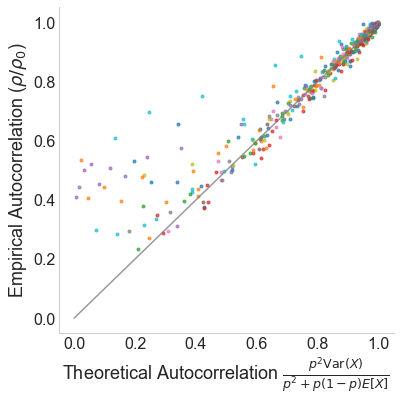

In [82]:
df = df_results.groupby(['user','sample_rate']).mean()
df = df.reset_index()

# sns.lmplot(x="x_norm", y="ratio", scatter_kws={"s": 1,'alpha':0.05}, data=df)
fig, ax = plt.subplots(figsize=(6, 6))


for u in df_results.user.unique():
    plot_df = df[df.user==u]
    plt.plot(plot_df.x_norm, plot_df.ratio, '.', alpha=0.7 )

plt.plot([0,1],[0,1], color='grey', alpha=0.8)

ax.grid(color='grey', linestyle='--', linewidth=0.25, alpha=0.5)
#removing top and right borders
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.xlabel(r'Theoretical Autocorrelation $\frac{ p^2 \mathrm{Var}(X)}{p^2 + p(1-p)E[X]}$')
plt.ylabel(r'Empirical Autocorrelation ($\rho/\rho_0$)')
plt.savefig(fig_folder/'twitter_user_theoretical.pdf', bbox_inches='tight')

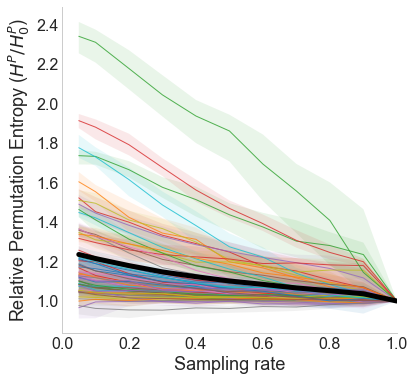

In [83]:
#plot entropy

yy = []
xx = []
fig, ax = plt.subplots(figsize=(6, 6))
for user in users:
    if user==9219012 or user==1391871:  #remove from plot because it messes with the scale
        continue
    x,y = plot_entropy_ratio(df_results, p_sample=p_sample, label=user)
#     if np.max(y)>4:
#         print(user,np.max(y))
    yy.append(y)
    xx.append(x)

    
entropy_values = copy.deepcopy(yy)
    
#Average of all
y = np.mean(np.array(yy), axis=0)
# y_q1 = np.quantile(np.array(yy), q=0.25, axis=0)
# y_q3 = np.quantile(np.array(yy), q=0.75, axis=0)
plt.plot(x,y,label='Average', linewidth=5, color='black')
# plt.fill_between(x, y_q1, y_q3, alpha=0.1, color='black')


# plt.legend(bbox_to_anchor=(1, 0.8), ncol=1)
plt.xlim(0,1.)

ax.grid(color='grey', linestyle='--', linewidth=0.25, alpha=0.5)
#removing top and right borders
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# ax.set_yscale('log')

plt.xlabel('Sampling rate')
plt.ylabel(r'Relative Permutation Entropy ($H^P/H^P_0$)')
plt.savefig(fig_folder/'twitter_user_entropy_ratio.pdf', bbox_inches='tight')



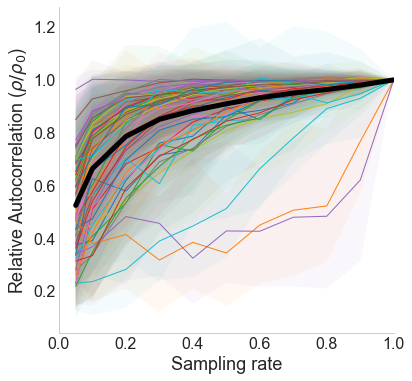

In [84]:
#plot autocorrelation 
fig, ax = plt.subplots(figsize=(6, 6))
yy = []
xx = []
for h in users:
    x,y = plot_autocorr_ratio(df_results, p_sample, label=h)
    yy.append(y)
    xx.append(x)

autocorr_values = copy.deepcopy(yy)    
    
#Average all
y = np.mean(np.array(yy), axis=0)
# y_q1 = np.quantile(np.array(yy), q=0.25, axis=0)
# y_q3 = np.quantile(np.array(yy), q=0.75, axis=0)
plt.plot(x,y,label='Average', linewidth=5, color='black')
# plt.fill_between(x, y_q1, y_q3, alpha=0.1, color='black') 
    
# plt.legend(bbox_to_anchor=(1, 0.8), ncol=1)
plt.xlim(0,1.)

ax.grid(color='grey', linestyle='--', linewidth=0.25, alpha=0.5)
#removing top and right borders
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)



plt.xlabel('Sampling rate')
plt.ylabel(r'Relative Autocorrelation ($\rho/\rho_0$)')
plt.savefig(fig_folder/'twitter_user_autocorr_ratio.pdf', bbox_inches='tight')


In [85]:
#TS clsutering
from tslearn.utils import to_time_series_dataset
from tslearn.preprocessing import TimeSeriesScalerMeanVariance


formatted_time_series = to_time_series_dataset(entropy_values)
print(formatted_time_series.shape)

formatted_time_series = TimeSeriesScalerMeanVariance(mu=0., std=1.).fit_transform(formatted_time_series)

n_clusters = 3

from tslearn.clustering import TimeSeriesKMeans,KShape
from tslearn.metrics import sigma_gak
seed = 0
np.random.seed(seed)

# metric : {“euclidean”, “dtw”, “softdtw”} (default: “euclidean”)
km = TimeSeriesKMeans(n_clusters=n_clusters, n_init=50,random_state=seed,max_iter=100 )
# km = KShape(n_clusters=n_clusters, n_init=50,random_state=seed,max_iter=100)


km.fit(formatted_time_series)
y_pred = km.fit_predict(formatted_time_series)
# km.fit(ini_cluster)
# y_pred = km.predict(formatted_time_series)

for i in range(n_clusters):
    s = len([x for x in y_pred if x==i])
    print(i,s)

(56, 11, 1)
0 9
1 3
2 44


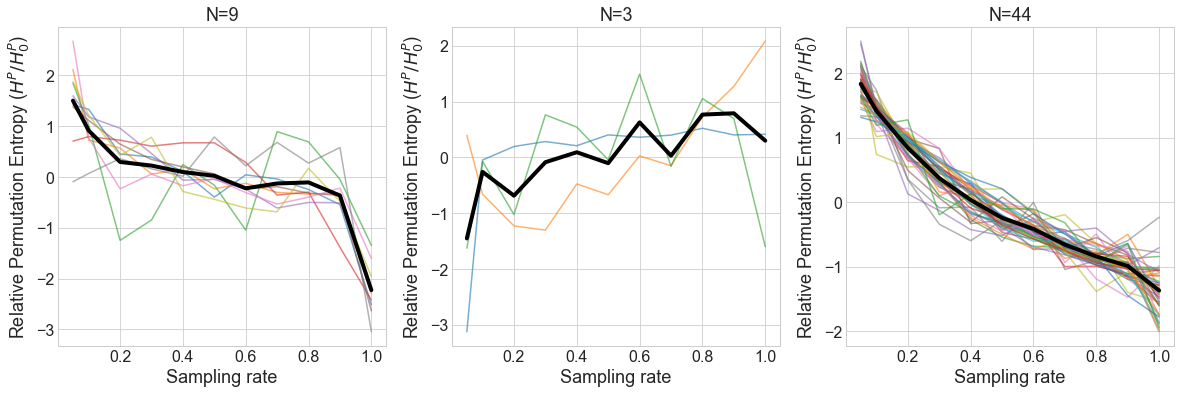

In [86]:
plt.figure(figsize=(20,20))
for yi in range(n_clusters):
    plt.subplot(n_clusters, n_clusters, yi + 1)
    for i in range(len(y_pred)):
        if yi==y_pred[i]:
            plt.plot(xx[0], formatted_time_series[i], alpha=.6)
    plt.plot(xx[0],km.cluster_centers_[yi].ravel(), "k-", linewidth=4)
#     plt.ylim(0.8, 1.7)
#     if yi == 1:
    s = len([x for x in y_pred if x==yi])
    plt.title("N={}".format(s))
    plt.xlabel('Sampling rate')
    plt.ylabel(r'Relative Permutation Entropy ($H^P/H^P_0$)')
    

plt.savefig(fig_folder/'twitter_user_cluster_ent.pdf', bbox_inches='tight')

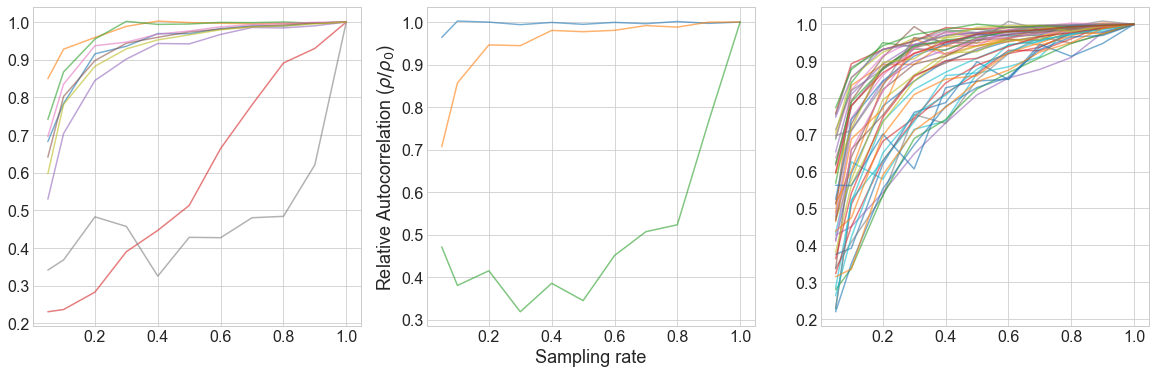

In [87]:
plt.figure(figsize=(20,20))
for yi in range(n_clusters):
    plt.subplot(n_clusters, n_clusters, yi + 1)
    for i in range(len(y_pred)):
        if yi==y_pred[i]:
            plt.plot(xx[0], autocorr_values[i], alpha=.6)
#     plt.plot(xx[0],km.cluster_centers_[yi].ravel(), "r-")
#     plt.ylim(0.8, 1.7)
    if yi == 1:
#         plt.title("Autocorrelation")
        plt.xlabel('Sampling rate')
        plt.ylabel(r'Relative Autocorrelation ($\rho/\rho_0$)')
        
plt.savefig(fig_folder/'twitter_user_cluster_auto', bbox_inches='tight')